## Inference

In [1]:
from pathlib import Path
import os

def load_files(folder_route: str):
    dir_path = Path(folder_route)
    folderContent = [os.path.join(dir_path, fn) for fn in next(os.walk(dir_path))[2]]
    return folderContent

TEST_IMAGE_DIR = './dataset/test/images/'
TEST_MASK_DIR = './dataset/test/masks/'

folder_test_image_content = load_files(TEST_IMAGE_DIR)
folder_test_mask_content = load_files(TEST_MASK_DIR)

print('Path: test/images, size: ',len(folder_test_image_content))
print('Path: test/masks, size: ',len(folder_test_image_content))

Path: test/images, size:  10
Path: test/masks, size:  10


In [2]:
from scripts.data_loader import load_and_transform_test_only

EPOCHS = 80
BATCH_SIZE =1
LEARNING_RATE = 3e-4
THRESHOLD = 0.7
USE_AMP="apex"
TRAIN_PERCENTAGE=0.7
ARCH = "Unet"
ENCODER_NAME="efficientnet-b5"
ENCODER_WEIGHTS="imagenet"
experiment=None
IMAGE_HEIGHT = 960
IMAGE_WIDTH   = 960
display_name = "Unet_150_0.7_efficientnet-b5_960_960_0.7_0.0003_1"

test_loader = load_and_transform_test_only(TEST_IMAGE_DIR, TEST_MASK_DIR, BATCH_SIZE, IMAGE_HEIGHT ,IMAGE_WIDTH)


c:\Users\carlo\Documents\Master\MasterTFM\model\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import ssl
import logging
import torch


ssl._create_default_https_context = ssl._create_unverified_context


logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cpu')
logging.info(f'Using device {device}')

INFO: Using device cpu


In [4]:
from scripts.segmentation_net import SolarPanelModel

model = SolarPanelModel(ARCH,ENCODER_NAME,ENCODER_WEIGHTS, in_channels=3, out_classes=1, learning_rate=LEARNING_RATE,
threshold=THRESHOLD, experiment=experiment )

model.load_state_dict(torch.load('models/'+display_name+'.pt'))
model.eval()

SolarPanelModel(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1, 1)
            (static_padding):

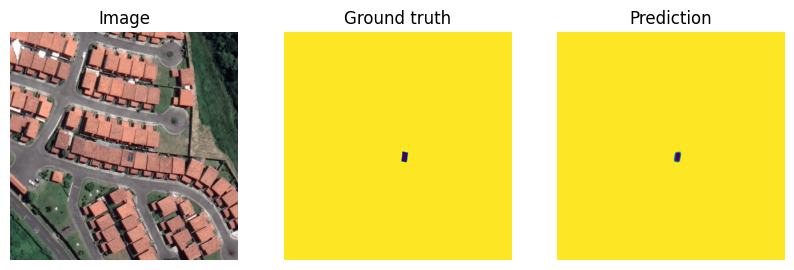

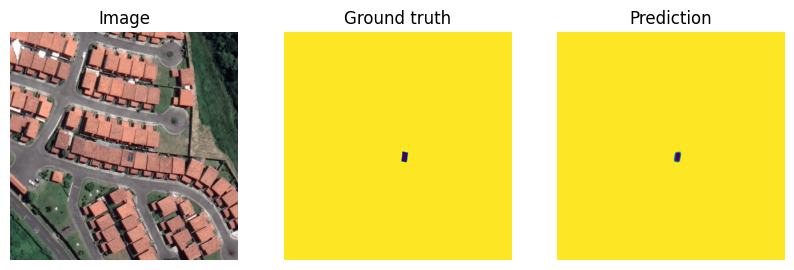

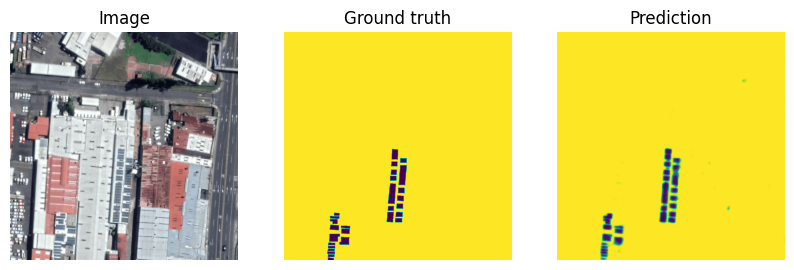

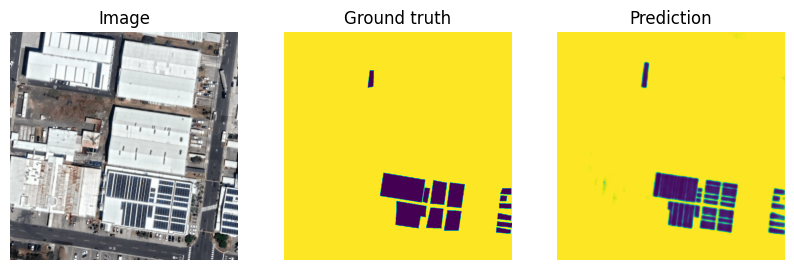

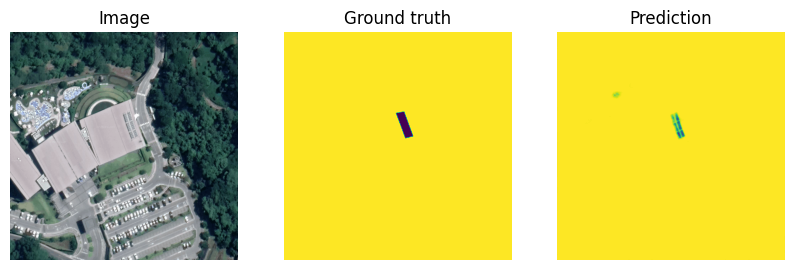

In [5]:
import torch
import matplotlib.pyplot as plt


for x in range(0, 5):
    batch= next(iter(test_loader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")
      
        plt.show()
